<h3>Setup</h3>

In [706]:
import numpy as np

import statistics

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.path as mplPath
import matplotlib.pyplot as pypl

from sklearn.cluster import KMeans

import folium
import folium.plugins

import time

import pickle

import urllib

from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import homogeneity_completeness_v_measure

from math import radians, cos, sin, asin, sqrt

import re

In [2]:
with open('communities_df_bu.txt', 'rb') as fp4:
    communities_df = pickle.load(fp4)
with open('small_boxes_clean_bu.txt', 'rb') as fp0:
    small_boxes_clean = pickle.load(fp0)
with open('searched_urls_bu.txt', 'rb') as fp1:
    searched_urls = pickle.load(fp1)
with open('query_results_bu.txt', 'rb') as fp2:
    query_results = pickle.load(fp2)
with open('venues_dict_same_len_bu.txt', 'rb') as fp3:
    venues_dict_same_len = pickle.load(fp3)
with open('venues_dict_clean_bu.txt', 'rb') as fp5:
    venues_dict_clean = pickle.load(fp5)

print('LOADED TO CHECKPOINT')

LOADED TO CHECKPOINT


<h3>Chicago Geography</h3>

In [3]:
# load chicago community boundaries
!wget -q -O 'chicago_communities.json' https://raw.githubusercontent.com/wbdean/chicago_geojson/master/chicagoCommunities.geojson
with open('chicago_communities.json') as json_data:
    chicago_communities = json.load(json_data)

In [4]:
# key on relevant section of geo data
communities_data = chicago_communities['features']

In [5]:
# identify center of Chicago
address = 'Chicago, IL'
geolocator = Nominatim(user_agent="chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [6]:
# create dataframe of Chicago communities, turns out some of this needed to be redone later for analysis but it works for this section
column_names = ['Community', 'Center', 'Bounding_Box', 'Boundaries', 'Price_Per_Sqft']
communities_df = pd.DataFrame(columns=column_names)
for data in communities_data:
    com = data['properties']['community']
    lats = []
    lons = []
    for i, j in enumerate(data['geometry']['coordinates']):
        for k, l in enumerate(data['geometry']['coordinates'][i]):
            for m, n in enumerate(data['geometry']['coordinates'][i][k]): # coordinates consists of nested lists, this pulls out each polygon from each of those lists
                lats.append(n[1])
                lons.append(n[0])
    cntr = [sum(lats)/len(lats), sum(lons)/len(lons)] # locate the center point of each community, this should be per polygon really but doesn't have much impact and is replaced later
    box = [[min(lats), min(lons)], [max(lats), max(lons)]] # bounding box of the community, from SW corner to NE corner of all the community's coordinates
    bnd = data['geometry']['coordinates'] # the full set of boundaries for the community
    communities_df = communities_df.append({'Community': com,
                                          'Center': cntr,
                                          'Bounding_Box': box,
                                          'Boundaries': bnd}, ignore_index=True)
communities_df.head()

,Community,Center,Bounding_Box,Boundaries,Price_Per_Sqft
0,DOUGLAS,"[41.83704625550661, -87.61378193832607]","[[41.8237, -87.63], [41.8457, -87.6027]]","[[[[-87.6091, 41.8447], [-87.6092, 41.8446], [...",NaN
1,OAKLAND,"[41.82245954545456, -87.59926227272719]","[[41.8168, -87.6126], [41.8314, -87.5922]]","[[[[-87.5922, 41.8169], [-87.5923, 41.8169], [...",NaN
2,FULLER PARK,"[41.80933510638297, -87.63231170212777]","[[41.7945, -87.6364], [41.8237, -87.6286]]","[[[[-87.6288, 41.8019], [-87.6288, 41.8018], [...",NaN
3,GRAND BOULEVARD,"[41.81253795180725, -87.61962048192778]","[[41.8019, -87.6294], [41.824, -87.6064]]","[[[[-87.6067, 41.8168], [-87.6067, 41.8166], [...",NaN
4,KENWOOD,"[41.809835933147646, -87.59028802228414]","[[41.8023, -87.6067], [41.817, -87.58]]","[[[[-87.5922, 41.8169], [-87.5922, 41.8168], [...",NaN


In [7]:
# create bounding box for all of chicago

swlats = []
swlons = []
nelats = []
nelons = []

for i, row in communities_df.iterrows():
    swlats.append(row[2][0][0])
    swlons.append(row[2][0][1])
    nelats.append(row[2][1][0])
    nelons.append(row[2][1][1])

chicago_sw = [min(swlats), min(swlons)]
chicago_ne = [max(nelats), max(nelons)]
chicago_box = [chicago_sw, chicago_ne]

chicago_box

[[41.6446, -87.9401], [42.023, -87.5241]]

In [8]:
# calculate the dimensions of the Chicago bounding box as measured in lat/lon, for reference only

box_dims_ll = [chicago_box[1][0]-chicago_box[0][0], chicago_box[1][1]-chicago_box[0][1]]
box_dims_ll

[0.3784000000000063, 0.4159999999999968]

In [9]:
box_dims_m = [box_dims_ll[0]*111111, box_dims_ll[1]*111111] # approximate conversion to meters from lat/lon
small_box_dims_m = [box_dims_m[0]/200, box_dims_m[1]/200] # if we divide it up into 200x200, 40,000 little boxes, each box will have approximately these dimensions
small_box_dims_m

[210.22201200000347, 231.11087999999822]

In [10]:
# cut Chicago up into 40,000 little boxes

small_boxes = {}
small_box_x = box_dims_ll[1]/200
small_box_y = box_dims_ll[0]/200

small_box_s = chicago_box[0][0]
small_box_w = chicago_box[0][1]
small_box_n = small_box_s + small_box_y
small_box_e = small_box_w + small_box_x

box_indexer = 1
box_y_indexer = 1
box_x_indexer = 1

while box_x_indexer <= 200:
    
    while box_y_indexer <= 200:
        
        small_boxes[box_indexer] = [small_box_s, small_box_w, small_box_n, small_box_e]
        small_box_w = small_box_e
        small_box_e = small_box_e + small_box_x
        box_y_indexer = box_y_indexer + 1
        box_indexer = box_indexer + 1
        
    box_y_indexer = 1
    small_box_w = chicago_box[0][1]
    small_box_e = small_box_w + small_box_x 
    
    small_box_s = small_box_n
    small_box_n = small_box_n + small_box_y
    box_x_indexer = box_x_indexer + 1
    
len(small_boxes)

40000

In [11]:
# get the geometry of Chicago to be compared with the boxes

chicago_polys = []
for i, row in communities_df.iterrows():
    bnds = row[3]
    for idx1, itm1 in enumerate(bnds):
        for idx2, itm2 in enumerate(bnds[idx1]):
                chicago_polys.append(np.array(itm2))

len(chicago_polys)

80

In [58]:
# remove the boxes which don't intersect with Chicago's boundaries, we only want to search Foursquare in relevant areas
# otherwise we risk running up our query quota, slowing performance, etc etc etc

small_boxes_clean = small_boxes.copy()
for k, v in small_boxes.items():
    intersect = 0
    small_bbox = matplotlib.transforms.Bbox([[v[1], v[0]], [v[3], v[2]]]) # convert each small box to a bounding box for use by matplotlib
    for poly in chicago_polys:
        chicago_poly_path = mplPath.Path(np.array(poly)) # convert community bounds paths for use by matplotlib
        if intersect == 1: # if a box intersects with one community, that's sufficient, and we can move on to the next
            continue
        if chicago_poly_path.intersects_bbox(small_bbox) == True:
            intersect = 1
    if intersect == 0:
        del small_boxes_clean[k]

len(small_boxes_clean)

17176

<h2>Foursquare Queries</h2>

In [12]:
client_id       = 'YJW1WOKSXWAZZNJ22KCTKZWDF0RVQQUXXOTKEFJ0L1Y4MT2V'
client_secret   = '4XIF2OEU4CI34LC5JNY5XCFJFAP4MJTHZ1AWCJBM3CWQR4LR'
version         = '20180605'
intent          = 'browse'

# assign a query URL to each of our small boxes, could do this in the next step one-at-a-time but nah

for k, v in small_boxes_clean.items():
    sw = str(v[0])+','+str(v[1])
    ne = str(v[2])+','+str(v[3])
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&intent={}&sw={}&ne={}'.format(
        client_id,
        client_secret,
        version,
        intent,
        sw,
        ne)
    v.append(url)

In [14]:
searched_urls = []
query_results = []

In [65]:
# get the POIs within each of our small boxes
# if we did it for all of chicago it returned only a tiny amount of results in comparison
# hence the breakdown into little boxes, each to be queried

c = 0

for k, v in small_boxes_clean.items():
    if v[4] in searched_urls:
        continue
    else:
        try:
            results = requests.get(v[4]).json()['response']['groups'][0]['items']
            v.append(results)
            query_results.append(results)
            searched_urls.append(v[4])
            if c < 2500:
                c = c + 1
            else:
                print(len(query_results), 'results retrieved')
                go_on = input('Continue')
                if go_on == '1':
                    c = 0
                    continue
                else:
                    print('Exited')
                    break
        except:
            print(len(query_results), 'results retrieved')
            go_on = input('Continue?')
            if go_on == '1':
                continue
            else:
                print('Exited')
                break
                
len(query_results)

Complete


In [114]:
# check our results
# which boxes returned results?
# which came up with nothing?

query_results_true = {}
query_results_false = {}
query_results_all = {}
query_results_indexer = 0

for q in query_results:
    query_results_all[query_results_indexer] = q
    if len(q) == 0:
        query_results_false[query_results_indexer] = q
    if len(q) > 0:
        query_results_true[query_results_indexer] = q
    query_results_indexer = query_results_indexer + 1
        
print('Total queries:', len(query_results_all))
print('Fruitful queries:', len(query_results_true))
print('Null results:', len(query_results_false))

Total queries: 17176
Fruitful queries: 6061
Null results: 11115


In [147]:
# create a dictionary of all venues which we pulled from the queries

venues_dict = {}
venues_indexer = 0

for k, v in query_results_true.items():
    for ven in v:
        try:
            venues_dict[venues_indexer] = [
                ven['venue']['id'],
                ven['venue']['name'],
                ven['venue']['categories'][0]['name'],
                [ven['venue']['location']['lat'], ven['venue']['location']['lng']]
                ]
        except:
            continue
        try: # try to pull an address, which not all venues have
            venues_dict[venues_indexer].append(ven['venue']['location']['address'])
            venues_dict[venues_indexer].append(ven['venue']['location']['city'])
            venues_dict[venues_indexer].append(ven['venue']['location']['state'])
            venues_dict[venues_indexer].append(ven['venue']['location']['postalCode'])
        except:
            venues_indexer = venues_indexer + 1
            continue
        venues_indexer = venues_indexer + 1

print('Extracted information of', len(venues_dict), 'venues')

Extracted information of 17024 venues


In [7]:
venues_dict_same_len = venues_dict.copy()
no_address_counter = 0
for k, v in venues_dict_same_len.items():
    if len(v) < 8:
        no_address_counter = no_address_counter + 1
        while len(v) < 8:
            venues_dict_same_len[k] = v.append('null') # make them all the same length so we can work with them in the same dataframe if we want to later on
            
print('Found complete addresses for', len(venues_dict_same_len)-no_address_counter, 'venues')

Found complete addresses for 14279 venues


In [75]:
venues_dict_clean = venues_dict_same_len.copy()

for k, v in venues_dict_same_len.items():
    try:
        if len(v) < 8:
            del venues_dict_clean[k] # but for now we don't want to
    except:
        del venues_dict_clean[k] # just in case
            
len(venues_dict_clean)

14279

In [81]:
for k, v in venues_dict_clean.items():
    try:
        if v[8] == True: # if we've already added the associated community, skip - not really necessary but w/e
            continue
    except:
        venue_communities = {} # let's hope the length is always 1, otherwise we've got a problem
        for i, row in communities_df.iterrows():
            community_polys = [] # inefficient but i compute the polygons for each community for each key, should pull this out of the loop but what's done is done
            bnds = row[3] # this won't be the last time I do this, hooray redundancy
            for idx1, itm1 in enumerate(bnds):
                for idx2, itm2 in enumerate(bnds[idx1]):
                    community_polys.append(np.array(itm2))
            for community_poly in community_polys:
                community_poly_path = mplPath.Path(np.array(community_poly), closed=True)
                if i not in venue_communities.keys() and community_poly_path.contains_point((v[3][1],v[3][0])) == True:
                    venue_communities[i] = row[0]
        venues_dict_clean[k].append(venue_communities)
    
venues_dict_clean[10000]

['4d9b60957668f04dafc0d093',
 'Barnes & Noble',
 'Bookstore',
 [41.91169402096545, -87.63169324371994],
 '2429 Sycamore Rd.',
 'DeKalb',
 'IL',
 '60115',
 {67: 'LINCOLN PARK'}]

In [12]:
# create dataframe from our dictionary of venues
# Associated Communities was there in case there was more than one community associated with a venue, but this didn't happen so it just gets deleted later in this block
venues_df = pd.DataFrame(venues_dict_clean).transpose()
venues_df.columns = ['ID', 'Name', 'Category', 'Coordinates', 'Address', 'City', 'State', 'Postal_Code', 'Associated_Communities']
venues_df['Community_ID'] = None
venues_df['Community_Name'] = None
for i, row in venues_df.iterrows():
    for k, v in row[8].items():
        row[9] = k
        row[10] = v
venues_df['Associated_Communities'] = venues_df['Associated_Communities'].map(str).replace(to_replace='{}', value=np.nan)
venues_df = venues_df.dropna().reset_index().drop(['index', 'Associated_Communities'], axis=1) # let's make sure we can work with all the venues here

venues_df.shape

(13781, 10)

In [13]:
venues_df.head()

,ID,Name,Category,Coordinates,Address,City,State,Postal_Code,Community_ID,Community_Name
0,4f326f6119836c91c7d7829a,Papa Damiani Pizza and Restaurant,Pizza Place,"[41.64462, -87.61442]",13800 Lincoln Ave,Dolton,IL,60419,50,RIVERDALE
1,4f32bd8a19836c91c7f55406,Four Winds Yacht Club,Nightlife Spot,"[41.644683, -87.607873]",826 E 138th St,Riverdale,IL,60827,50,RIVERDALE
2,4b798dbcf964a520fa002fe3,Pier 11 Marina,Harbor / Marina,"[41.64623777963077, -87.60143640943127]",826 E 138th St,Chicago,IL,60827,50,RIVERDALE
3,513161dde4b0ee8b2aef57f4,Windjammers,Bar,"[41.646317, -87.560124]",137th And Nixie,Chicago,IL,60633,51,HEGEWISCH
4,4b15aa1bf964a5200ab223e3,NICTD's South Shore - Hegewisch Station,Train Station,"[41.645642961192884, -87.54077514979706]",13664 S Brainard Ave.,Chicago,IL,60633,51,HEGEWISCH


In [14]:
venue_counts = venues_df[['Name', 'Community_Name']].groupby('Community_Name').count()

venue_counts

,Name
Community_Name,
ALBANY PARK,181
ARCHER HEIGHTS,87
ARMOUR SQUARE,139
ASHBURN,137
AUBURN GRESHAM,112
AUSTIN,232
AVALON PARK,42
AVONDALE,237
BELMONT CRAGIN,262


In [15]:
# get dummies of each venue category for analyzing/clustering

community_dummies = pd.get_dummies(venues_df[['Category']], prefix="", prefix_sep="")

community_dummies['ID'] = venues_df['Community_ID']
community_dummies['Name'] = venues_df['Community_Name']

arranged_columns = [community_dummies.columns[-2]] + [community_dummies.columns[-1]] + list(community_dummies.columns[:-2])
community_dummies = community_dummies[arranged_columns]

community_dummies.shape

(13781, 469)

In [16]:
community_grouped = community_dummies.groupby('Name').mean().reset_index()

community_grouped.shape

(77, 468)

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# a lot of stuff to make the resulting DF more readable, but shamelessly copied from prev. assignment
top_venues_columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        top_venues_columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venues_columns.append('{}th Most Common Venue'.format(ind+1))
community_venues_sorted = pd.DataFrame(columns=top_venues_columns)
community_venues_sorted['Name'] = community_grouped['Name']

for ind in np.arange(community_grouped.shape[0]):
    community_venues_sorted.iloc[ind, 1:] = return_most_common_venues(community_grouped.iloc[ind, :], num_top_venues) # get most common venues by running the return most common venues function

community_venues_sorted.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALBANY PARK,Mexican Restaurant,Park,Grocery Store,Bakery,Bus Station,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Sandwich Place,Ice Cream Shop
1,ARCHER HEIGHTS,Mexican Restaurant,Bakery,Bar,Mobile Phone Shop,Restaurant,Food,Grocery Store,Park,Pizza Place,Pet Store
2,ARMOUR SQUARE,Chinese Restaurant,Baseball Stadium,Bar,Asian Restaurant,Bakery,Dim Sum Restaurant,Seafood Restaurant,Sports Bar,Tea Room,Korean Restaurant
3,ASHBURN,Park,Fast Food Restaurant,Pizza Place,Donut Shop,Mexican Restaurant,American Restaurant,Bakery,Bar,Chinese Restaurant,Sandwich Place
4,AUBURN GRESHAM,Fast Food Restaurant,Lounge,Seafood Restaurant,Discount Store,Fried Chicken Joint,Park,Liquor Store,Chinese Restaurant,Caribbean Restaurant,American Restaurant


<h2>Clustering</h2>

In [19]:
def cluster_me_baby(k):
    
    try:  # this weas a problem when re-loading the program, "Cluster" being or not being already inserted already, artifact of going from one-time run to a repeatedly called function
        temp_community_venues_sorted = community_venues_sorted.drop('Cluster', axis=1)
    except:
        temp_community_venues_sorted = community_venues_sorted
        
    chicago_clusters = community_grouped.drop('Name', axis=1)

    kclusters = k
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_clusters)

    temp_community_venues_sorted.insert(0, 'Cluster', kmeans.labels_) # add cluster labels to communities for this number k

    k_df = communities_df # create the full clustered dataframe for this number k
    k_df = k_df.join(temp_community_venues_sorted.set_index('Name'), on='Community') \
                                   .drop(['Center', 'Bounding_Box', 'Price_Per_Sqft'], axis=1)

    return k_df

In [700]:
try:
    community_venues_sorted.drop('Cluster', axis=1) # see the "try/except" section above
except:
    pass

cluster_dfs = {}
k = 1

while k <= 50:
    cluster_dfs[k]=cluster_me_baby(k=k) # create a dictionary comprised of the cluster dataframes for each number k between "k" and the number in the while loop
    k = k + 1

len(cluster_dfs)

50

In [593]:
cluster_dfs[5]['Cluster'].unique()

array([1, 0, 3, 4, 2])

<h2>Visualizing Clusters</h2>

In [636]:
# create a map of the clusters for a given cluster dataframe

def plot_me_real_good(kclusters, k_df):
    
    cs = np.arange(kclusters)
    ys = [i + cs + (i*cs)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    print(rainbow)

    feature_group = folium.FeatureGroup(name = 'K = '+str(kclusters), overlay = False, control = False)

    folium.GeoJson(
        chicago_communities,
        style_function = lambda x: { # colouring each community in accordance with its cluster
            'fillColor':rainbow[k_df.loc[k_df['Community']==x['properties']['community']]['Cluster'].values[0]],
            'fillOpacity':0.5,
            'weight':1,
            'color':'black'
        }
        ).add_to(feature_group)

    return feature_group

In [637]:
k_maps = {} # store the map for each cluster dataframe we created above

for k, v in cluster_dfs.items():
    k_map = folium.Map(location=[latitude, longitude], zoom_start=10) # center on Chicago
    k_map.add_child(plot_me_real_good(kclusters=k,k_df=v)) 
    k_maps[k] = k_map

len(k_maps)

['#8000ff']
['#8000ff', '#ff0000']
['#8000ff', '#80ffb4', '#ff0000']
['#8000ff', '#2adddd', '#d4dd80', '#ff0000']
['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']
['#8000ff', '#1996f3', '#4df3ce', '#b2f396', '#ff964f', '#ff0000']
['#8000ff', '#2c7ef7', '#2adddd', '#80ffb4', '#d4dd80', '#ff7e41', '#ff0000']
['#8000ff', '#386df9', '#12c8e6', '#5af8c8', '#a4f89f', '#ecc86f', '#ff6d38', '#ff0000']
['#8000ff', '#4062fa', '#00b5eb', '#40ecd4', '#80ffb4', '#c0eb8d', '#ffb360', '#ff5f30', '#ff0000']
['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


10

In [23]:
k_maps[8]

In [ ]:
# investigate clusters
# this could be done better since we use 0-indexing in the dictionary but not for the number of clusters
print('Max K:', len(cluster_dfs))
input_1 = cluster_dfs[int(input('Enter K: '))]

In [25]:
input_2 = int(input('Enter Cluster (0-indexed) ')) 
input_1.loc[input_1['Cluster'] == input_2].drop(['Boundaries', 'Cluster'], axis=1)

Enter Cluster (0-indexed)  4


,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,RIVERDALE,Park,Harbor / Marina,Pizza Place,Martial Arts Dojo,Grocery Store,Coffee Shop,Nightlife Spot,Residential Building (Apartment / Condo),Mountain,Food


<h2>Property pricing data</h2>

In [24]:
# filter our venue DF to restaurants
# Why restaurants? Restaurants have consistent infrastructure requirements, so it should control for variation in building/property features
restaurants_df = venues_df[venues_df['Category'].str.match('.*Restaurant.*')]
restaurants_df.shape

(2923, 10)

In [25]:
# which communities don't have restaurants?
restaurant_communities = restaurants_df['Community_Name'].unique().tolist()
all_communities = venues_df['Community_Name'].unique().tolist()
starving_communities = []
for i in all_communities:
    if i not in restaurant_communities:
        starving_communities.append(i)
starving_communities

['RIVERDALE', 'BURNSIDE', 'OAKLAND']

In [26]:
# let's look at the communities which don't have restaurants
starving_df = venues_df[venues_df['Community_Name'].str.match('RIVERDALE|BURNSIDE|OAKLAND')]
starving_df

,ID,Name,Category,Coordinates,Address,City,State,Postal_Code,Community_ID,Community_Name
0,4f326f6119836c91c7d7829a,Papa Damiani Pizza and Restaurant,Pizza Place,"[41.64462, -87.61442]",13800 Lincoln Ave,Dolton,IL,60419,50,RIVERDALE
1,4f32bd8a19836c91c7f55406,Four Winds Yacht Club,Nightlife Spot,"[41.644683, -87.607873]",826 E 138th St,Riverdale,IL,60827,50,RIVERDALE
2,4b798dbcf964a520fa002fe3,Pier 11 Marina,Harbor / Marina,"[41.64623777963077, -87.60143640943127]",826 E 138th St,Chicago,IL,60827,50,RIVERDALE
15,4e1602ad1495a0bf953d10d1,Uncle Jim not Jaime's boat,Harbor / Marina,"[41.65102934366344, -87.61962858499885]",water,Chicago,IL,60827,50,RIVERDALE
16,4cbf06e37dc9a093915b36f5,Beaubien Woods Boat Launch,Harbor / Marina,"[41.650372698080865, -87.5905179977417]",13400 S. Doty Ave,Chicago,IL,60633,50,RIVERDALE
19,551c56f9498e692af10d80b5,Pangea Lakes Apartments,Residential Building (Apartment / Condo),"[41.6526131, -87.61817043]",13300 S Indiana Ave,Riverdale,IL,60827,50,RIVERDALE
20,4f6b838a7bebf48a25686c4d,Carver (George Washington) Park,Park,"[41.65292197018113, -87.59933710098265]",939 E 132nd St,Chicago,IL,60827,50,RIVERDALE
21,4e9c7fbe754aab1caa077fdf,Carver Park,Park,"[41.65377170512857, -87.59899377822876]",939 E. 133rd St.,Chicago,IL,60627,50,RIVERDALE
22,4f247722e4b0ed339876f7a5,Mount Trashmore,Mountain,"[41.653688224888604, -87.58345410837467]",133,Riverdale,IL,60827,50,RIVERDALE
37,4e9dae2bf9f494d561c398a9,Golden Gate Park,Park,"[41.6590301928088, -87.61079549789429]",13000 S Eberhart Ave,Chicago,IL,60627,50,RIVERDALE


Guess we'll proceed despite no restaurants in these communities, since they're pretty lacking in POIs overall...

There are things like "Pizza Place" and whatnot but I'll leave that for another time.

In [27]:
restaurants_df.head()

,ID,Name,Category,Coordinates,Address,City,State,Postal_Code,Community_ID,Community_Name
5,4bb4102949bdc9b6da830c10,Burger King,Fast Food Restaurant,"[41.644667, -87.5404208]",13770 S Avenue O,Chicago,IL,60633,51,HEGEWISCH
12,4e512b1c1f6eae4d2531ae5a,Mancini's,American Restaurant,"[41.649671, -87.545632]",13508 S Brandon Ave,Chicago,IL,60633,51,HEGEWISCH
24,4f4d437de4b0accb044fca6d,Los Cantaritos,Mexican Restaurant,"[41.65253477592613, -87.54704828352394]",13343 S Baltimore Ave,Chicago,IL,60633,51,HEGEWISCH
26,4cd4c048a5b346885a0d8a50,China Garden #2,Chinese Restaurant,"[41.65273901456053, -87.5472124471702]",13328 S Baltimore Ave,Chicago,IL,60633,51,HEGEWISCH
28,4bf806c64a67c928929224cf,Chicago Pita Kitchen,Greek Restaurant,"[41.65504631568464, -87.55399686278597]",13227 S Brainard Ave,Chicago,IL,60633,51,HEGEWISCH


In [28]:
# compute distance between two coordinates using haversine function
# hooray geometry

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c*r

In [29]:
community_poly_centers = {} # this again

for i, row in communities_df.iterrows():
    temp_centers = {}
    poly_indexer = 0
    bnds = row[3] # full bounds
    for idx1, itm1 in enumerate(bnds): # nest lvl1
        for idx2, itm2 in enumerate(bnds[idx1]): # nest lvl2
            for indx3, itm3 in enumerate(bnds[idx1][idx2]): # nest lvl3, this is where the actual set of coords are contained for each polygon
                temp_lats = []
                temp_lons = []
                temp_lats.append(itm3[1])
                temp_lons.append(itm3[0])
            temp_centers[poly_indexer] = [sum(temp_lats)/len(temp_lats), sum(temp_lons)/len(temp_lons)] # find the center point of each polygon within this community
            poly_indexer = poly_indexer + 1
    community_poly_centers[row[0]] = temp_centers

community_poly_centers['OHARE']

{0: [41.9864, -87.8366], 1: [41.9981, -87.94], 2: [42.0054, -87.9335]}

In [30]:
# Calculate the distance between each POI and the center point of each enclosed polygon of each community

restaurant_distances = {}

for k1, v1 in community_poly_centers.items(): # k1 = community, v1 = polygon indices
    restaurant_distances_community = {}
    for k2, v2 in v1.items(): # k2 = polygon index, v2 = center point of the polygon
        restaurant_distances_poly = {}
        lat1 = v2[0]
        lon1 = v2[1]
        venue_indexer = 0
        for i, row in restaurants_df.iterrows(): # for each polygon center point for each community, calculate the distance to each restaurant venue
            temp_value = row.tolist()
            lat2 = row[3][0]
            lon2 = row[3][1]
            dist = haversine(lon1=lon1, lat1=lat1, lon2=lon2, lat2=lat2)
            temp_value.append(dist) # add the distance as another item to the venue's details
            restaurant_distances_poly[venue_indexer] = temp_value
            venue_indexer = venue_indexer + 1
        restaurant_distances_community[k2] = restaurant_distances_poly
    restaurant_distances[k1] = restaurant_distances_community

In [31]:
len(restaurant_distances)

77

In [32]:
len(restaurant_distances['OHARE'])

3

In [33]:
len(restaurant_distances['DOUGLAS'][0])

2923

In [34]:
# create a dataframe showing closest distance between a community's polys' center points and each restaurant
restaurant_distances_dfs = {}
for k1, v1 in restaurant_distances.items(): # k1 = community, v1 = polygon indices
    temp_community_df = pd.DataFrame()
    for k2, v2 in v1.items(): # k2 = polygon index, v2 = venue details (including distance from this poly's center)
        temp_poly_df = pd.DataFrame.from_dict(v2, orient='index', columns=['ID','Name','Category','Coordinates','Street','City','State','Postal_Code','Community_ID','Community','Distance']).drop(['Community_ID','Community'], axis=1)
        temp_poly_df['Community'] = k1
        temp_poly_df['Poly_ID'] = k2
        temp_community_df = temp_community_df.append(temp_poly_df, ignore_index=True) # combine the poly dfs together per community
    restaurant_distances_dfs[k1] = temp_community_df.sort_values('Distance').drop_duplicates(subset='ID') # we only want the distance to nearest poly center for each community
    
restaurant_distances_dfs['OHARE'].shape

(2923, 11)

In [35]:
restaurant_distances_dfs['OHARE'][0:5]

,ID,Name,Category,Coordinates,Street,City,State,Postal_Code,Distance,Community,Poly_ID
2648,51fdfcfe894be73ac969137c,Morton's The Steakhouse - Rosemont,Restaurant,"[41.981008, -87.841105]",9525 Bryn Mawr Ave,Rosemont,IL,60018,0.705782,OHARE,0
2705,5b3665aeda7080002da529cd,Fooda,Restaurant,"[41.985189, -87.845467]",8745 W Higgins Rd,Chicago,IL,60631,0.745147,OHARE,0
2609,4b575eeff964a520233428e3,Plush Pup,American Restaurant,"[41.97670667229568, -87.83669221805451]",5344 N Cumberland Ave,Chicago,IL,60656,1.077876,OHARE,0
2635,57cf2011498ece34869618da,Avalon Bar and Grill,American Restaurant,"[41.978243, -87.844008]",5431 N East River Rd,Chicago,IL,60656,1.094358,OHARE,0
2849,4b40b0d0f964a520eab925e3,Moretti's Ristorante,Italian Restaurant,"[42.002733480307604, -87.81756804979815]",6727 N Olmsted Ave,Chicago,IL,60631,2.402570,OHARE,0


In [223]:
# create dataframe of the distance between each community and each restaurant, a big combo of the above block
all_restaurant_distances_df = pd.DataFrame()

for v in restaurant_distances_dfs.values():
    all_restaurant_distances_df = all_restaurant_distances_df.append(v, ignore_index=True)

all_restaurant_distances_df.shape

(225071, 11)

In [224]:
# we will be querying a property details database to get relevant details like sqft, they'll be stored in these
all_query_results = {} # all results, for reference
rel_query_results = {} # the stuff we're actually interested in

In [225]:
# load latest saved query results
with open('all_query_results.txt', 'rb') as fp13:
    all_query_results = pickle.load(fp13)
print('Loaded all_query_results')
with open('rel_query_results.txt', 'rb') as fp12:
    rel_query_results = pickle.load(fp12)
print('Loaded rel_query_results')

Loaded all_query_results
Loaded rel_query_results


In [226]:
top_x = 30 # we want the nearest x restaurants to each community

top_x_restaurant_distances_df = pd.DataFrame()

for v in restaurant_distances_dfs.values():
    top_x_restaurant_distances_df = top_x_restaurant_distances_df.append(v[0:top_x], ignore_index=True)

top_x_restaurant_distances_df.shape

(2310, 11)

In [227]:
len(top_x_restaurant_distances_df['ID'].unique())

1357

In [228]:
len(top_x_restaurant_distances_df)

2310

In [229]:
# if each unqueried location is queried, it should run this number of queries, 
# consider it an upper bound, for making sure we don't overrun our 500/day quota with this API
to_search = []
for i in top_x_restaurant_distances_df['ID']:
    if not i in all_query_results.keys():
        to_search.append(i)
len(to_search)

0

In [230]:
counter = 100
passed = 0
queried = 0

for i, row in top_x_restaurant_distances_df.iterrows():
    if row[0] in all_query_results.keys(): # don't query if we already have the info, we have a limited quota
        passed = passed + 1
        continue
# ATTOM API query structure
    headers = {
        'apikey': '####',
        'accept': '####',
    }
    params = (
        ('address1', row[4]),
        ('address2', row[5]+', '+row[6]),
    )
    v = requests.get('https://search.onboard-apis.com/propertyapi/v1.0.0/property/expandedprofile', headers=headers, params=params).json()
    all_query_results[row[0]] = v # add all results to this dict
    queried = queried + 1
    try: # if it worked, add all of this info to the relevant results dict
        rel_query_results[row[0]] = [
            str(v['status']['msg']),
            str(v['property'][0]['identifier']['obPropId']),
            str(v['property'][0]['identifier']['fips']),
            str(v['property'][0]['identifier']['apn']),
            str(v['property'][0]['identifier']['attomId']),
            v['property'][0]['lot']['lotSize1'],
            v['property'][0]['lot']['lotSize2'],
            v['property'][0]['sale']['amount']['saleAmt'],
            v['property'][0]['sale']['calculation']['pricePerSizeUnit'],
            v['property'][0]['building']['size']['grossSize'],
            str(v['property'][0]['building']['size']['sizeInd']),
            v['property'][0]['assessment']['assessed']['assdImprValue'],
            v['property'][0]['assessment']['assessed']['assdLandValue'],
            v['property'][0]['assessment']['assessed']['assdTtlValue'],
            v['property'][0]['assessment']['market']['mktImprValue'],
            v['property'][0]['assessment']['market']['mktLandValue'],
            v['property'][0]['assessment']['market']['mktTtlValue'],
        ]
    except: # if it didn't work, geocoding error, no results, etc, we should know that too, so add the sxtatus message and nulls, can filter later
        temp = [str(v['status']['msg'])]
        while len(temp) < 17:
            temp.append(np.nan)
        rel_query_results[row[0]] = temp
        pass
    if counter > 1:
        counter = counter - 1
        continue
    else:
        ctn = input('100 queries complete, continue? ')
        if ctn == 'y':
            counter = 100
            continue
        else:
            print('Stopped')
            break
                
print('Querying complete, skipped', passed, 'queried', queried)

Querying complete, skipped 2310 queried 0


In [231]:
len(all_query_results)

1357

In [232]:
len(rel_query_results)

1357

In [233]:
# save latest query results
with open('all_query_results.txt', 'wb') as fp13:
    pickle.dump(all_query_results, fp13)
print('Saved all_query_results')
with open('rel_query_results.txt', 'wb') as fp12:
    pickle.dump(rel_query_results, fp12)
print('Saved rel_query_results')

Saved all_query_results
Saved rel_query_results


In [234]:
# create dataframe from our relevant query results
rel_query_df = pd.DataFrame.from_dict(
    rel_query_results,
    orient='index', 
    columns=[
        'Status',
        'Onboard_ID',
        'fips',
        'APN',
        'ATTOM_ID',
        'Lot_Acres',
        'Lot_SqFt',
        'Sale_Amount',
        'Price_Per_Size_Unit',
        'Gross_Building_Size',
        'Building_Size_Units',
        'Assessed_Improvements',
        'Assessed_Land',
        'Assessed_Title',
        'Market_Improvements',
        'Market_Land',
        'Market_Title',])

rel_query_df.shape

(1357, 17)

In [237]:
# map the query results to our restaurants dataframe
all_restaurant_distances_df['Status'] = all_restaurant_distances_df['ID'].map(rel_query_df['Status'])
all_restaurant_distances_df['Onboard_ID'] = all_restaurant_distances_df['ID'].map(rel_query_df['Onboard_ID'])
all_restaurant_distances_df['fips'] = all_restaurant_distances_df['ID'].map(rel_query_df['fips'])
all_restaurant_distances_df['APN'] = all_restaurant_distances_df['ID'].map(rel_query_df['APN'])
all_restaurant_distances_df['ATTOM_ID'] = all_restaurant_distances_df['ID'].map(rel_query_df['ATTOM_ID'])
all_restaurant_distances_df['Lot_Acres'] = all_restaurant_distances_df['ID'].map(rel_query_df['Lot_Acres'])
all_restaurant_distances_df['Sale_Amount'] = all_restaurant_distances_df['ID'].map(rel_query_df['Sale_Amount'])
all_restaurant_distances_df['Price_Per_Size_Unit'] = all_restaurant_distances_df['ID'].map(rel_query_df['Price_Per_Size_Unit'])
all_restaurant_distances_df['Gross_Building_Size'] = all_restaurant_distances_df['ID'].map(rel_query_df['Gross_Building_Size'])
all_restaurant_distances_df['Assessed_Improvements'] = all_restaurant_distances_df['ID'].map(rel_query_df['Assessed_Improvements'])
all_restaurant_distances_df['Assessed_Land'] = all_restaurant_distances_df['ID'].map(rel_query_df['Assessed_Land'])
all_restaurant_distances_df['Assessed_Title'] = all_restaurant_distances_df['ID'].map(rel_query_df['Assessed_Title'])
all_restaurant_distances_df = all_restaurant_distances_df.replace(to_replace=0.0,value=np.nan)
all_restaurant_distances_df['Total_Assessed'] = all_restaurant_distances_df['Assessed_Improvements']+all_restaurant_distances_df['Assessed_Land']+all_restaurant_distances_df['Assessed_Title']
all_restaurant_distances_df['Assessed_FMV_Ratio_Estimate'] = all_restaurant_distances_df['Total_Assessed']/all_restaurant_distances_df['Sale_Amount']

In [260]:
all_restaurant_distances_df.drop_duplicates(subset=['ID']).describe()

,Distance,Poly_ID,Lot_Acres,Sale_Amount,Price_Per_Size_Unit,Gross_Building_Size,Assessed_Improvements,Assessed_Land,Assessed_Title,Total_Assessed,Assessed_FMV_Ratio_Estimate,FMV_Estimate,FMV_Estimate_Per_Acre,FMV_Estimate_Per_Building_Sqft
count,2923.000000,0.0,694.000000,2.000000e+02,165.000000,3.750000e+02,7.000000e+02,7.060000e+02,7.120000e+02,6.940000e+02,2923.00,6.940000e+02,5.100000e+02,281.000000
mean,11.148850,NaN,0.283520,4.409090e+06,484.793939,2.633573e+04,2.273706e+05,7.319247e+04,2.961142e+05,6.024874e+05,0.25,2.409950e+06,5.736690e+06,277.548648
std,5.355625,NaN,1.122206,1.643752e+07,1478.213249,2.114987e+05,1.976501e+06,3.932901e+05,2.227768e+06,4.511569e+06,0.00,1.804627e+07,6.834357e+06,246.825564
min,0.687167,NaN,0.011400,3.100000e+04,12.000000,2.000000e+02,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,0.25,1.600000e+01,2.921864e+05,30.921905
25%,6.308281,NaN,0.068800,2.450000e+05,76.000000,1.700000e+03,1.805950e+04,5.908500e+03,2.637050e+04,5.422100e+04,0.25,2.168840e+05,2.527023e+06,125.873333
50%,10.862236,NaN,0.082150,5.492500e+05,143.000000,3.000000e+03,3.496500e+04,1.230400e+04,4.943900e+04,1.012770e+05,0.25,4.051080e+05,3.863431e+06,203.355294
75%,15.022994,NaN,0.174925,1.200000e+06,342.000000,6.050000e+03,6.769875e+04,2.870550e+04,9.822600e+04,1.995680e+05,0.25,7.982720e+05,6.177502e+06,363.308235
max,29.112929,NaN,19.345400,1.060000e+08,12500.000000,3.914400e+06,4.502676e+07,4.742752e+06,4.862901e+07,9.725802e+07,0.25,3.890321e+08,8.954693e+07,2282.880000


In [248]:
all_restaurant_distances_df['Assessed_FMV_Ratio_Estimate'] = 0.25 # as per https://www.civicfed.org/sites/default/files/100405_CookCountyAssessmentPrimer.pdf, which is more-or-less in-line with above
# Create estimates based on provided values and excluding outliers
all_restaurant_distances_df['FMV_Estimate'] = all_restaurant_distances_df['Total_Assessed']*(1/all_restaurant_distances_df['Assessed_FMV_Ratio_Estimate'])
all_restaurant_distances_df['FMV_Estimate_Per_Acre'] = all_restaurant_distances_df['FMV_Estimate']/all_restaurant_distances_df[all_restaurant_distances_df['Lot_Acres']<0.175]['Lot_Acres']
all_restaurant_distances_df['FMV_Estimate_Per_Building_Sqft'] = all_restaurant_distances_df['FMV_Estimate']/all_restaurant_distances_df[all_restaurant_distances_df['Gross_Building_Size']<6100]['Gross_Building_Size']

In [272]:
community_medians_df = all_restaurant_distances_df \
                        .groupby('Community') \
                        .apply(lambda x: x.iloc[0:top_x].reset_index()) \
                        .set_index('index') \
                        .groupby('Community') \
                        .mean() \
                        .drop(['Poly_ID','Distance'], axis=1)
community_medians_df['FMV_Estimate'] = community_medians_df['FMV_Estimate'].fillna(community_medians_df['Total_Assessed']*1/(community_medians_df['Assessed_FMV_Ratio_Estimate']))
community_medians_df['FMV_Estimate_Per_Acre'] = community_medians_df['FMV_Estimate_Per_Acre'].fillna(community_medians_df['FMV_Estimate']/community_medians_df['Lot_Acres'])
community_medians_df['FMV_Estimate_Per_Building_Sqft'] = community_medians_df['FMV_Estimate_Per_Building_Sqft'].fillna(community_medians_df['FMV_Estimate']/community_medians_df['Gross_Building_Size'])
community_medians_df.describe()

,Lot_Acres,Sale_Amount,Price_Per_Size_Unit,Gross_Building_Size,Assessed_Improvements,Assessed_Land,Assessed_Title,Total_Assessed,Assessed_FMV_Ratio_Estimate,FMV_Estimate,FMV_Estimate_Per_Acre,FMV_Estimate_Per_Building_Sqft
count,77.000000,7.500000e+01,70.000000,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,77.00,7.700000e+01,7.700000e+01,77.000000
mean,0.299103,3.208859e+06,397.042256,2.554803e+04,2.835371e+05,7.313389e+04,3.218245e+05,7.395439e+05,0.25,2.958175e+06,5.269354e+06,268.690045
std,0.297711,7.783058e+06,730.983237,1.322014e+05,1.387580e+06,2.178718e+05,1.319826e+06,3.242003e+06,0.00,1.296801e+07,5.266083e+06,129.816027
min,0.069038,1.070000e+05,55.666667,1.540000e+03,1.452467e+04,6.066667e+03,2.202010e+04,4.840956e+04,0.25,1.936382e+05,1.619351e+06,33.267198
25%,0.140133,4.189643e+05,138.000000,2.978571e+03,3.765424e+04,1.471867e+04,5.614600e+04,1.122920e+05,0.25,4.491680e+05,2.746697e+06,191.551853
50%,0.192555,6.212500e+05,228.000000,4.060000e+03,5.231512e+04,1.934611e+04,7.520747e+04,1.504149e+05,0.25,6.016597e+05,3.590922e+06,242.801647
75%,0.342443,1.517188e+06,296.800000,6.346667e+03,8.260429e+04,3.154950e+04,1.087023e+05,2.174047e+05,0.25,8.696187e+05,5.401208e+06,306.323968
max,1.550664,4.414960e+07,3928.000000,1.139125e+06,1.175738e+07,1.409533e+06,1.081544e+07,2.639618e+07,0.25,1.055847e+08,3.322701e+07,819.059701


In [286]:
community_medians_df[['Sale_Amount','Price_Per_Size_Unit','Total_Assessed','FMV_Estimate','FMV_Estimate_Per_Acre','FMV_Estimate_Per_Building_Sqft']].describe()

,Sale_Amount,Price_Per_Size_Unit,Total_Assessed,FMV_Estimate,FMV_Estimate_Per_Acre,FMV_Estimate_Per_Building_Sqft
count,7.500000e+01,70.000000,7.700000e+01,7.700000e+01,7.700000e+01,77.000000
mean,3.208859e+06,397.042256,7.395439e+05,2.958175e+06,5.269354e+06,268.690045
std,7.783058e+06,730.983237,3.242003e+06,1.296801e+07,5.266083e+06,129.816027
min,1.070000e+05,55.666667,4.840956e+04,1.936382e+05,1.619351e+06,33.267198
25%,4.189643e+05,138.000000,1.122920e+05,4.491680e+05,2.746697e+06,191.551853
50%,6.212500e+05,228.000000,1.504149e+05,6.016597e+05,3.590922e+06,242.801647
75%,1.517188e+06,296.800000,2.174047e+05,8.696187e+05,5.401208e+06,306.323968
max,4.414960e+07,3928.000000,2.639618e+07,1.055847e+08,3.322701e+07,819.059701


In [278]:
community_medians_df[['Sale_Amount','Price_Per_Size_Unit','Total_Assessed','FMV_Estimate','FMV_Estimate_Per_Acre','FMV_Estimate_Per_Building_Sqft']].round()

,Sale_Amount,Price_Per_Size_Unit,Total_Assessed,FMV_Estimate,FMV_Estimate_Per_Acre,FMV_Estimate_Per_Building_Sqft
Community,,,,,,
ALBANY PARK,931667.0,401.0,121524.0,486097.0,3264266.0,189.0
ARCHER HEIGHTS,1636333.0,444.0,134256.0,537024.0,2430318.0,273.0
ARMOUR SQUARE,2110000.0,368.0,141391.0,565564.0,7530939.0,192.0
ASHBURN,469000.0,297.0,104740.0,418959.0,3307225.0,258.0
AUBURN GRESHAM,527900.0,193.0,87302.0,349209.0,2878433.0,261.0
AUSTIN,1027333.0,91.0,188385.0,753540.0,4628242.0,233.0
AVALON PARK,582143.0,257.0,131242.0,524968.0,3118054.0,299.0
AVONDALE,620600.0,192.0,125934.0,503735.0,6201078.0,258.0
BELMONT CRAGIN,772625.0,337.0,90391.0,361562.0,2813335.0,243.0


(array([ 2., 17., 30., 14.,  5.,  6.,  1.,  0.,  0.,  2.]),
 array([ 33.26719838, 111.84644864, 190.42569889, 269.00494914,
        347.58419939, 426.16344964, 504.74269989, 583.32195014,
        661.90120039, 740.48045065, 819.0597009 ]),
 <a list of 10 Patch objects>)

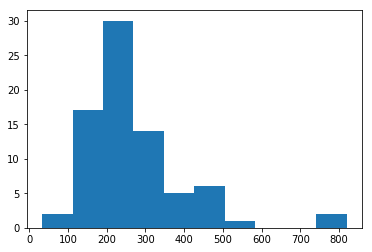

In [299]:
ppsqft_plot = pypl.hist(community_medians_df['FMV_Estimate_Per_Building_Sqft'])
ppsqft_plot

(array([ 2.,  6.,  3.,  8., 12.,  9., 12.,  5.,  5.,  5.]),
 array([ 92.68931856, 119.72801765, 146.76671675, 173.80541585,
        200.84411494, 227.88281404, 254.92151314, 281.96021223,
        308.99891133, 336.03761043, 363.07630952]),
 <a list of 10 Patch objects>)

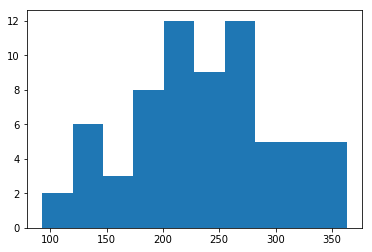

In [316]:
ppsqft_no_outs = []

for i in community_medians_df['FMV_Estimate_Per_Building_Sqft'].tolist():
    if 70.64500000000004 < i < 414.955:
        ppsqft_no_outs.append(i)
        
ppsqft_plot_no_outs = pypl.hist(ppsqft_no_outs)

ppsqft_plot_no_outs

In [ ]:
community_medians_df[['Sale_Amount','Price_Per_Size_Unit','Total_Assessed','FMV_Estimate','FMV_Estimate_Per_Acre','FMV_Estimate_Per_Building_Sqft']][]

In [321]:
sqft_price_lst = community_medians_df['FMV_Estimate_Per_Building_Sqft'].tolist()
sqft_price_med = statistics.median(sqft_price_lst)
sqft_price_med

242.80164730223208

In [324]:
sqft_price_iqr = np.percentile(sqft_price_lst,75,interpolation='higher')-np.percentile(sqft_price_lst,25,interpolation='lower')
sqft_price_iqr

114.77211477411478

In [326]:
sqft_bins_upper = sqft_price_med+1.5*sqft_price_iqr
sqft_bins_upper

414.95981946340424

In [327]:
sqft_bins_lower = sqft_price_med-1.5*sqft_price_iqr
sqft_bins_lower

70.64347514105992

In [640]:
def bin_me_over(b):
    
    binadict_cumberbatch = {}
    bins = b
    if b == 1:
        binadict_cumberbatch[0] = [0, 99999]
    elif b == 2:
        binadict_cumberbatch[0] = [0, sqft_price_med]
        binadict_cumberbatch[1] = [sqft_price_med, 99999]
    else:
        bin_size = (sqft_bins_upper-sqft_bins_lower)/(bins-2)
        binadict_cumberbatch[0] = [0, sqft_bins_lower]
        bin_start = sqft_bins_lower
        for i in range(bins-1):
            binadict_cumberbatch[i+1] = [bin_start, bin_start+bin_size]
            bin_start = bin_start + bin_size
    
    bin_df_dict = {}
    for i, row in community_medians_df[['FMV_Estimate_Per_Building_Sqft']].iterrows():
        if row[0] < binadict_cumberbatch[0][0]:
            bin_df_dict[i] = [row[0], 0]
        if row[0] > binadict_cumberbatch[len(binadict_cumberbatch)-1][1]:
            bin_df_dict[i] = [row[0], len(binadict_cumberbatch)-1]
        for k, v in binadict_cumberbatch.items():
            if binadict_cumberbatch[k][0] < row[0] < binadict_cumberbatch[k][1]:
                bin_df_dict[i] = [row[0], k]
    bin_df = pd.DataFrame.from_dict(bin_df_dict, orient='index')
    bin_df = bin_df.reset_index()
    bin_df.columns=['Community', 'FMV_Estimate_Per_Building_Sqft','Bin']

    return bin_df

In [701]:
binned_dfs = {}
b = 1
max_b = 50

while b <= max_b:
    binned_dfs[b]=bin_me_over(b=b) # create a dictionary comprised of the cluster dataframes for each number k between "k" and the number in the while loop
    b=b+1

len(binned_dfs)

50

In [702]:
combined_dfs = {}

for k, v in binned_dfs.items():
    temp_df = v[['Community','Bin']]
    temp_df['Cluster'] = temp_df['Community'].map(cluster_dfs[k].set_index('Community')['Cluster'])
    combined_dfs[k]=temp_df

len(combined_dfs)

50

In [707]:
cluster_evaluation = {}
for k, v in combined_dfs.items():
    cluster_evaluation[k] = homogeneity_completeness_v_measure(labels_true=v['Bin'], labels_pred=v['Cluster'])

len(cluster_evaluation)

50

In [708]:
cluster_evaluation

{1: (1.0, 1.0, 1.0),
 2: (0.01328445068337308, 0.13144206779928838, 0.02413014125824381),
 3: (0.12464084608233933, 0.08225212724552096, 0.0991041364726081),
 4: (0.10211865460271664, 0.10449775098999993, 0.10329450567583258),
 5: (0.1688909737583318, 0.1856205173975799, 0.17686100854211964),
 6: (0.13297685086227312, 0.15399199175845962, 0.14271493682059852),
 7: (0.19827103292920534, 0.21715704740588526, 0.20728474619381385),
 8: (0.16888562276306462, 0.23184037774171382, 0.19541784923969058),
 9: (0.1629323038515315, 0.17738208309738093, 0.16985042401618303),
 10: (0.21237325447969016, 0.2404767290360112, 0.22555295321209856),
 11: (0.2729153817687228, 0.3000219143806679, 0.28582742248580395),
 12: (0.28055052976496025, 0.33927653318136297, 0.307131510742355),
 13: (0.29911329230378986, 0.34317982384606077, 0.3196348968463213),
 14: (0.30662422278210705, 0.3594504965566058, 0.3309425382327548),
 15: (0.3144431073860227, 0.3758717404227034, 0.34242426745500276),
 16: (0.3504083421159

<h1>*****END*****</h1>